In [6]:
!pip install nb_black lightgbm pyarrow umap-learn BorutaShap

In [12]:
%load_ext lab_black
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import glob
import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import umap
import lightgbm as lgb
import numpy as np

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from utils import DATA_SETS, gather_df

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


water_spring_amiata
target_flow_rate_bugnano


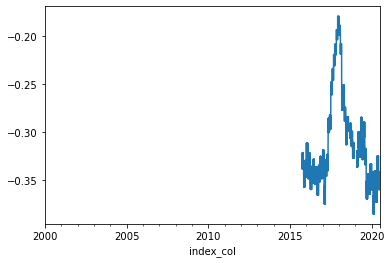

target_flow_rate_arbure


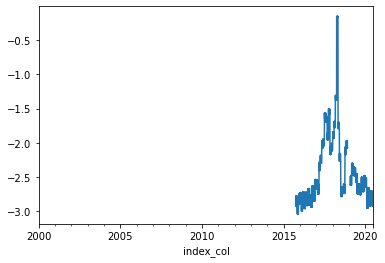

target_flow_rate_ermicciolo


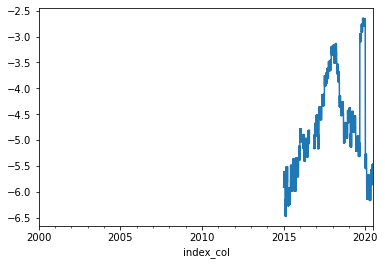

target_flow_rate_galleria_alta


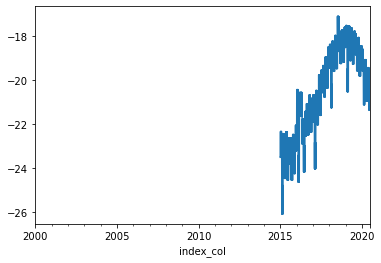

In [15]:
for dataset in DATA_SETS[1:2]:
    print(dataset)
    df = gather_df(dataset, True, False, False, True)
    for target_col in [c for c in df.columns if "target" in c]:
        print(target_col)
        df[target_col].plot()
        plt.show()

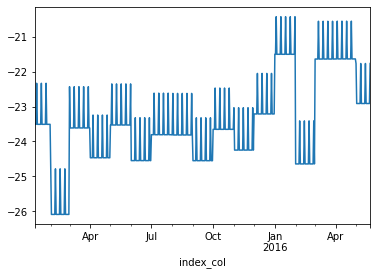

In [39]:
# kan zo'n variabele
df[[c for c in df.columns if "target" in c][3]].iloc[-2000:-1500].plot()

In [37]:
col = [c for c in df.columns if "target" in c][1]
df["dow"] = pd.to_datetime(df.index).dayofweek
df.pct_change().groupby(df.dow)[col].mean()

dow
0    0.049037
1    0.041215
2    0.001422
3   -0.001718
4    0.002334
5   -0.000649
6   -0.050896
Name: target_flow_rate_arbure, dtype: float64

In [34]:
df.dow

index_col
2000-01-01    5
2000-01-02    6
2000-01-03    0
2000-01-04    1
2000-01-05    2
             ..
2020-06-26    4
2020-06-27    5
2020-06-28    6
2020-06-29    0
2020-06-30    1
Name: dow, Length: 7487, dtype: int64

In [ ]:
results = []
data_sets = [
    "aquifer_auser",
    "water_spring_amiata",
    "aquifer_petrignano",
    "aquifer_doganella",
    "aquifer_luco",
    "river_arno",
    "lake_bilancino",
    #     "water_spring_lupa",
    #         "water_spring_madonna_di_canneto",
]
for dataset in data_sets:
    df = gather_df(dataset, True, True, False, True)

    for target_col in [c for c in df.columns if "target" in c]:
        for shift in [30, 60]:
            y = df[target_col].pct_change(shift).shift(-shift)

            pipeline = Pipeline(
                memory=None,
                steps=[
                    ("impute", KNNImputer()),
                    #                     ("scaling", StandardScaler(copy=True, with_mean=True, with_std=True)),
                    ("best", SelectFromModel(lgb.LGBMRegressor())),
                    #         ("dim_reduction", PCA(n_components=10)),
                    #                             ("dim_reduction", umap.UMAP(n_components=5)),
                ],
                verbose=False,
            )

            for split in range(3000, len(df.index) - 100, 100):

                X_train = df.iloc[:split]
                X_test = df.iloc[split + shift :]
                y_train = y.iloc[:split]
                y_test = y.iloc[split + shift :]

                x_filtered = ~pd.isna(y_train)

                if len(X_train[x_filtered]) < 1500:
                    continue
                if len(X_test) < 10:
                    continue

                #                 X_train_piped = pipeline.fit_transform(X_train[x_filtered], y_train[x_filtered])
                #                 X_test_piped = pipeline.transform(X_test)
                y_train = y_train[x_filtered]

                rmodel = lgb.LGBMRegressor()
                rmodel.fit(X_train[x_filtered], np.clip(y_train, -1, 10))

                p = rmodel.predict(X_test)
                dfp = pd.DataFrame(
                    {
                        "p": p,
                        "y": y_test,
                        "y_orig": df[target_col].iloc[split + shift :] * y_test,
                        "p_orig": df[target_col].iloc[split + shift :] * p,
                    }
                ).iloc[:100]
                dfp = dfp[~pd.isna(dfp.y)]
                mae = np.mean(np.abs(dfp.p - dfp.y))
                rmse = np.sqrt(np.mean(dfp.p - dfp.y) ** 2)

                results.append(
                    {
                        "dataset": dataset,
                        "split": split,
                        "mae": mae,
                        "rmse": rmse,
                        "type": "all",
                        "target_col": target_col,
                        "shift": shift,
                        "mae_orig": np.mean(np.abs(dfp.p_orig - dfp.y_orig)),
                        "rmse_orig": np.sqrt(np.mean(dfp.p_orig - dfp.y_orig) ** 2),
                    }
                )
                #                 feat_model = lgb.LGBMRegressor()
                #                 feat_model.fit(X_train_piped, y_train)

                #                 p = feat_model.predict(X_test_piped)
                #                 dfp = pd.DataFrame({"p": p, "y": y_test}).iloc[:100]
                #                 mae = np.mean(np.abs(dfp.p - dfp.y))
                #                 rmse= np.sqrt(np.mean(dfp.p - dfp.y)**2)
                #                 results.append({
                #                     'dataset': dataset,
                #                     'split': split,
                #                     'mae': mae,
                #                     'rmse': rmse,
                #                     'type': 'pipeline',
                #                      'target_col': target_col,
                #                     'shift': shift
                #                 })
                pd.DataFrame(results).to_json(
                    "./simres-pct-simplefeat-capped-target-incshifted.json"
                )